In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from arch import arch_model

%matplotlib inline


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)


In [3]:
df_jan = pd.read_csv('Khimki/Khimki_jan_2017.csv', sep=';', encoding='cp1251')
df_feb = pd.read_csv('Khimki/Khimki_feb_2017.csv', sep=';', encoding='cp1251')
df_mar = pd.read_csv('Khimki/Khimki_mar_2017.csv', sep=';', encoding='cp1251')
df_apr = pd.read_csv('Khimki/Khimki_apr_2017.csv', sep=';', encoding='cp1251')
df_may = pd.read_csv('Khimki/Khimki_may_2017.csv', sep=';', encoding='cp1251')
df_jun = pd.read_csv('Khimki/Khimki_jun_2017.csv', sep=';', encoding='cp1251')
frames = [df_jan, df_feb, df_mar, df_apr, df_may, df_jun]
df = pd.concat(frames, ignore_index=True)

In [4]:
df['P_FROM_STR'].value_counts()

ХИМКИ                           967848
МОСКВА ОКТЯБРЬСКАЯ              306521
ПЕТРОВСКО-РАЗУМОВСКОЕ           219924
ХОВРИНО                         138652
ЛЕВОБЕРЕЖНАЯ                     93664
СХОДНЯ                           79904
КРЮКОВО                          60525
ОСТАНКИНО                        57588
НАТИ                             50337
МОССЕЛЬМАШ                       41890
ГОРОД МОСКВА                     30404
НОВОПОДРЕЗКОВО                   21444
ПОДСОЛНЕЧНАЯ                     20325
ПОДРЕЗКОВО                       19413
ФИРСАНОВСКАЯ                     14456
РИЖСКАЯ                          11317
КЛИН                             10335
ПЛАНЕРНАЯ                         6663
ПОВАРОВО 1                        6424
ПОВАРОВКА                         4143
ТВЕРЬ                             3610
КОНАКОВО ГРЭС                     3607
Экспресс-код станции 2000015      2789
Экспресс-код станции 2002080      2618
АЛАБУШЕВО                         2453
БЕРЕЗКИ ДАЧНЫЕ           

In [5]:
df.tail()

,A_ID_ZFILE,B_ZNAME,C_DATE_TR,D_KONC_NUM,E_TURNIK_ID,F_TURNIKET_TYPE,G_HOUR_TR,H_MINUTE_TR,I_CLASS_P,J_NAME_P,...,N_NAME_KT,O_TIC_STR,P_FROM_STR,Q_TO_STR,R_NOSITEL,S_NUM_BPMF,T_TYPE_NULL,U_NUM_TK,V_NUM_CRY,W_STATION
2207395,159,Z_05000_170630.01,30.06.2017,1,11,Вход,23,47,0,ПАССАЖИРСКИЙ,...,"Разовый ""туда""",Станции,ХИМКИ,ФИРСАНОВСКАЯ,Билет,52149,560.0,NaN,NaN,ХИМКИ
2207396,159,Z_05000_170630.01,30.06.2017,1,16,Выход,23,47,0,ПАССАЖИРСКИЙ,...,"Разовый""туда-обр.""",Станции,ХИМКИ,МОСКВА ОКТЯБРЬСКАЯ,Билет,51327,314.0,NaN,NaN,ХИМКИ
2207397,159,Z_05000_170630.01,30.06.2017,1,15,Выход,23,47,0,ПАССАЖИРСКИЙ,...,"Разовый ""туда""",Станции,МОСКВА ОКТЯБРЬСКАЯ,ХИМКИ,Билет,54389,7791.0,NaN,NaN,ХИМКИ
2207398,159,Z_05000_170630.01,30.06.2017,1,11,Вход,23,50,0,ПАССАЖИРСКИЙ,...,"Разовый ""туда""",Станции,ХИМКИ,КРЮКОВО,Билет,52382,131.0,NaN,NaN,ХИМКИ
2207399,159,Z_05000_170630.01,30.06.2017,1,8,Вход,23,59,0,ПАССАЖИРСКИЙ,...,"Разовый ""туда""",Станции,ХИМКИ,СХОДНЯ,Билет,52147,504.0,NaN,NaN,ХИМКИ


In [6]:
#from_st_date = df[df['P_FROM_STR'].apply(lambda P_FROM_STR: P_FROM_STR == 'ХИМКИ')][['P_FROM_STR','C_DATE_TR']]

In [7]:
from_st_date = df[df['P_FROM_STR'].apply(lambda P_FROM_STR: P_FROM_STR != 'ХИМКИ' and P_FROM_STR[0:8] != 'Экспресс')][['P_FROM_STR','C_DATE_TR']]

In [8]:
#P_FROM_STR[0:8] != 'Экспресс'

In [9]:
from_st_date.head()

,P_FROM_STR,C_DATE_TR
5,ЛЕВОБЕРЕЖНАЯ,01.01.2017
13,СХОДНЯ,01.01.2017
14,СХОДНЯ,01.01.2017
21,ПЕТРОВСКО-РАЗУМОВСКОЕ,01.01.2017
24,СХОДНЯ,01.01.2017


In [10]:
from_st_date.C_DATE_TR = from_st_date.C_DATE_TR.apply(lambda C_DATE_TR: C_DATE_TR.replace('.', '/'))

In [11]:
from_st_date.C_DATE_TR = from_st_date['C_DATE_TR'].apply(lambda d: datetime.strptime(d, '%d/%m/%Y'))

In [12]:
from_st_date['P_FROM_STR'].value_counts(normalize=True)

МОСКВА ОКТЯБРЬСКАЯ       0.252380
ПЕТРОВСКО-РАЗУМОВСКОЕ    0.181078
ХОВРИНО                  0.114162
ЛЕВОБЕРЕЖНАЯ             0.077120
СХОДНЯ                   0.065790
КРЮКОВО                  0.049834
ОСТАНКИНО                0.047416
НАТИ                     0.041446
МОССЕЛЬМАШ               0.034491
ГОРОД МОСКВА             0.025034
НОВОПОДРЕЗКОВО           0.017656
ПОДСОЛНЕЧНАЯ             0.016735
ПОДРЕЗКОВО               0.015984
ФИРСАНОВСКАЯ             0.011903
РИЖСКАЯ                  0.009318
КЛИН                     0.008510
ПЛАНЕРНАЯ                0.005486
ПОВАРОВО 1               0.005289
ПОВАРОВКА                0.003411
ТВЕРЬ                    0.002972
КОНАКОВО ГРЭС            0.002970
АЛАБУШЕВО                0.002020
БЕРЕЗКИ ДАЧНЫЕ           0.001945
РЕДКИНО                  0.001932
ЗАВИДОВО                 0.001466
РЕШЕТНИКОВО              0.000802
ДОН 0                    0.000688
ГОЛОВКОВО                0.000599
ПОКРОВКА                 0.000585
ФРОЛОВСКОЕ    

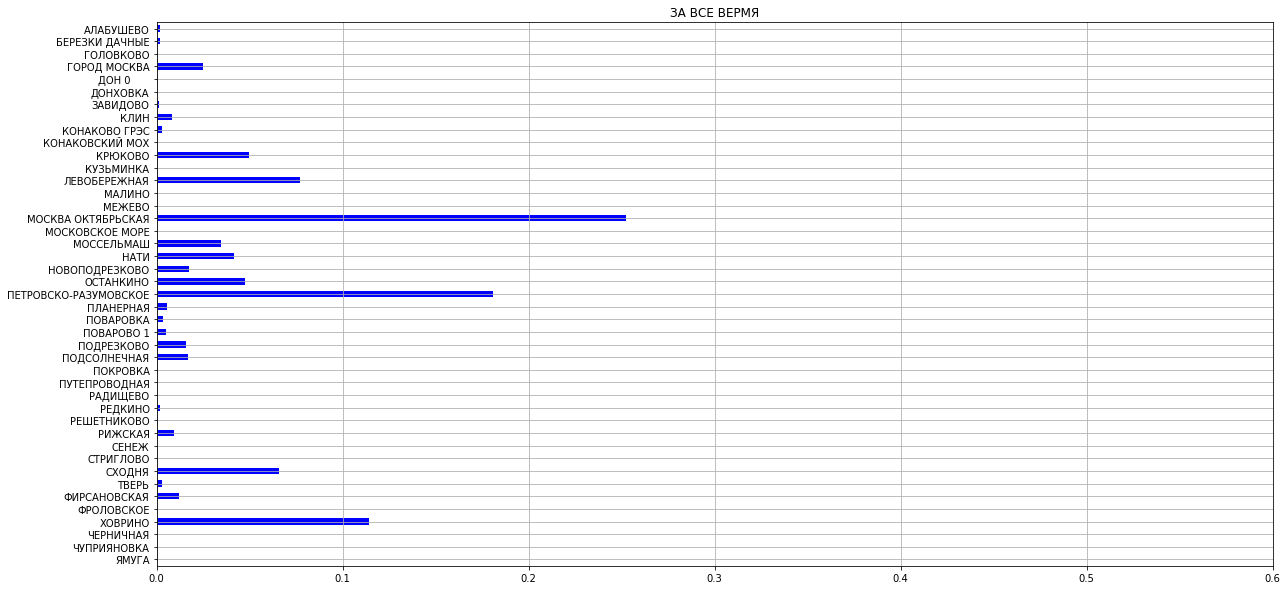

In [13]:
all_time = from_st_date['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
all_time.plot(kind='barh', title='ЗА ВСЕ ВЕРМЯ', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

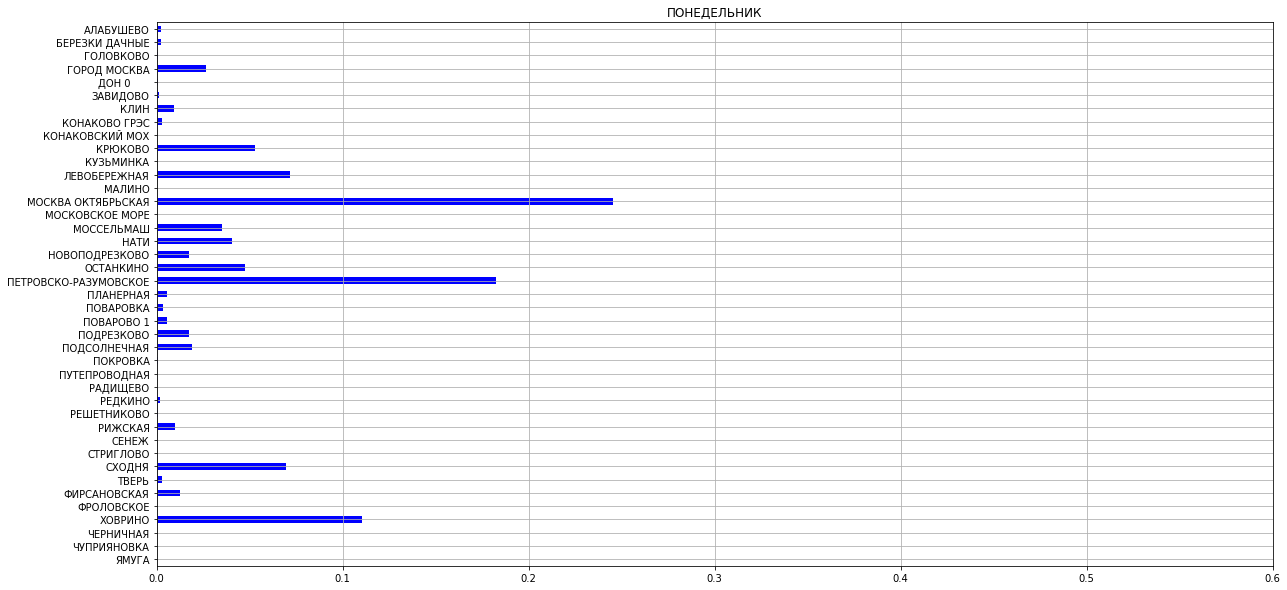

In [14]:
monday = from_st_date[from_st_date['C_DATE_TR'].apply(lambda d: d.weekday() == 0)]
monday = monday['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
monday.plot(kind='barh', title='ПОНЕДЕЛЬНИК', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

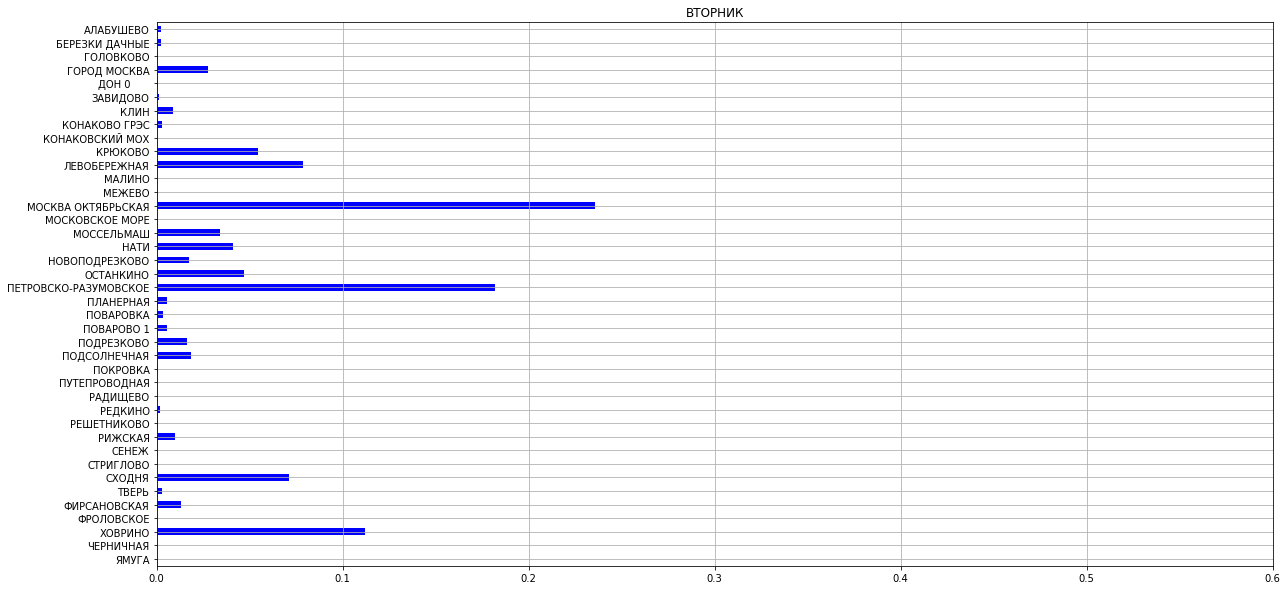

In [15]:
tuesday = from_st_date[from_st_date['C_DATE_TR'].apply(lambda d: d.weekday() == 1)]
tuesday = tuesday['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
tuesday.plot(kind='barh', title='ВТОРНИК', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

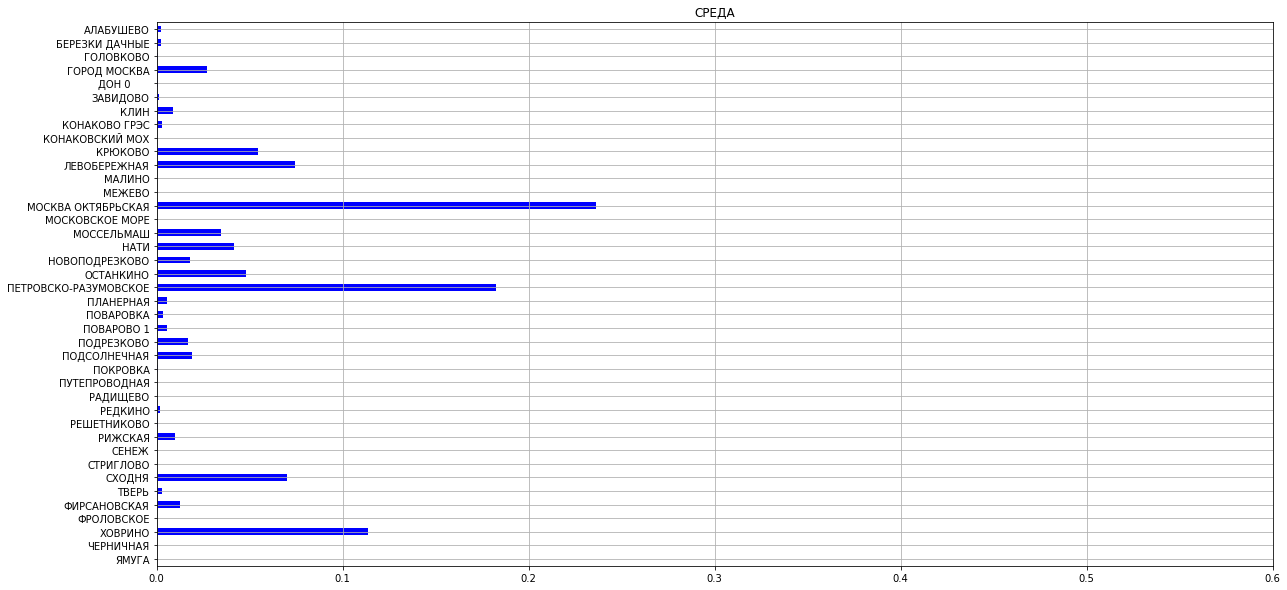

In [16]:
wednesday = from_st_date[from_st_date['C_DATE_TR'].apply(lambda d: d.weekday() == 2)]
wednesday = wednesday['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
wednesday.plot(kind='barh', title='СРЕДА', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

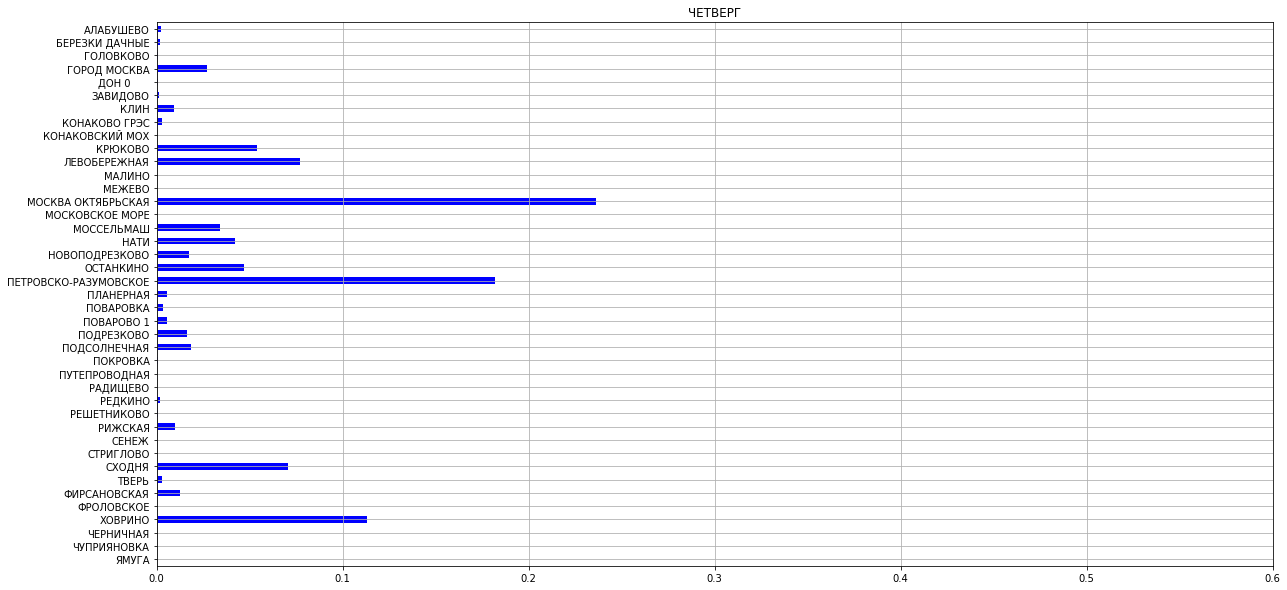

In [17]:
thursday = from_st_date[from_st_date['C_DATE_TR'].apply(lambda d: d.weekday() == 3)]
thursday = thursday['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
thursday.plot(kind='barh', title='ЧЕТВЕРГ', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

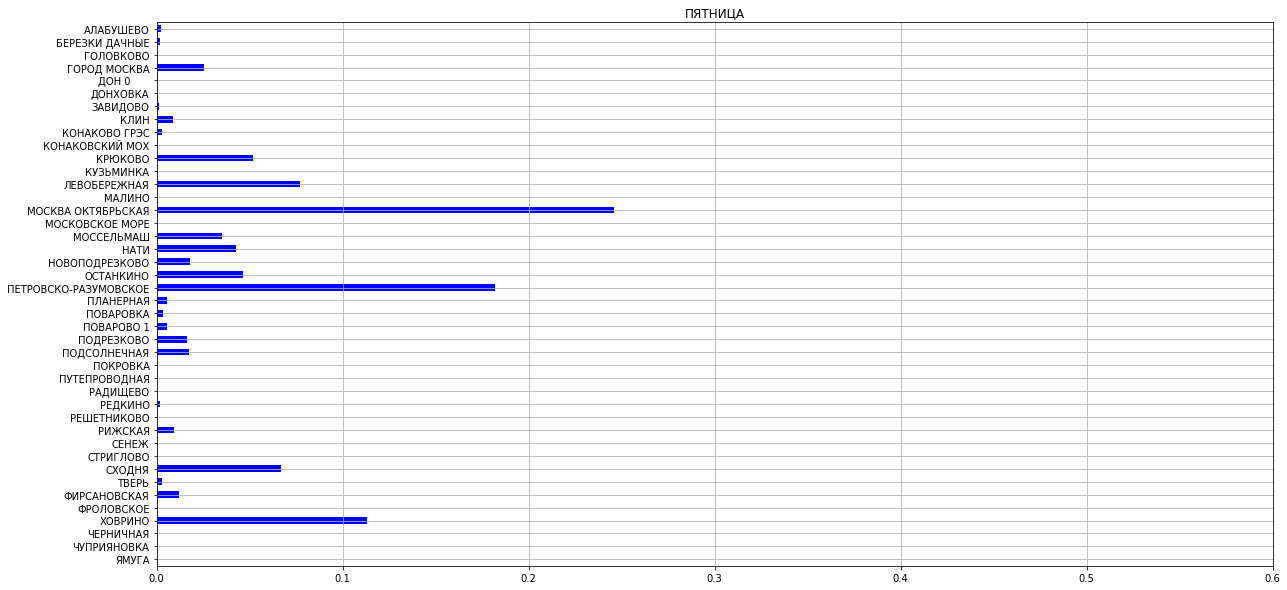

In [18]:
friday = from_st_date[from_st_date['C_DATE_TR'].apply(lambda d: d.weekday() == 4)]
friday = friday['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
friday.plot(kind='barh', title='ПЯТНИЦА', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

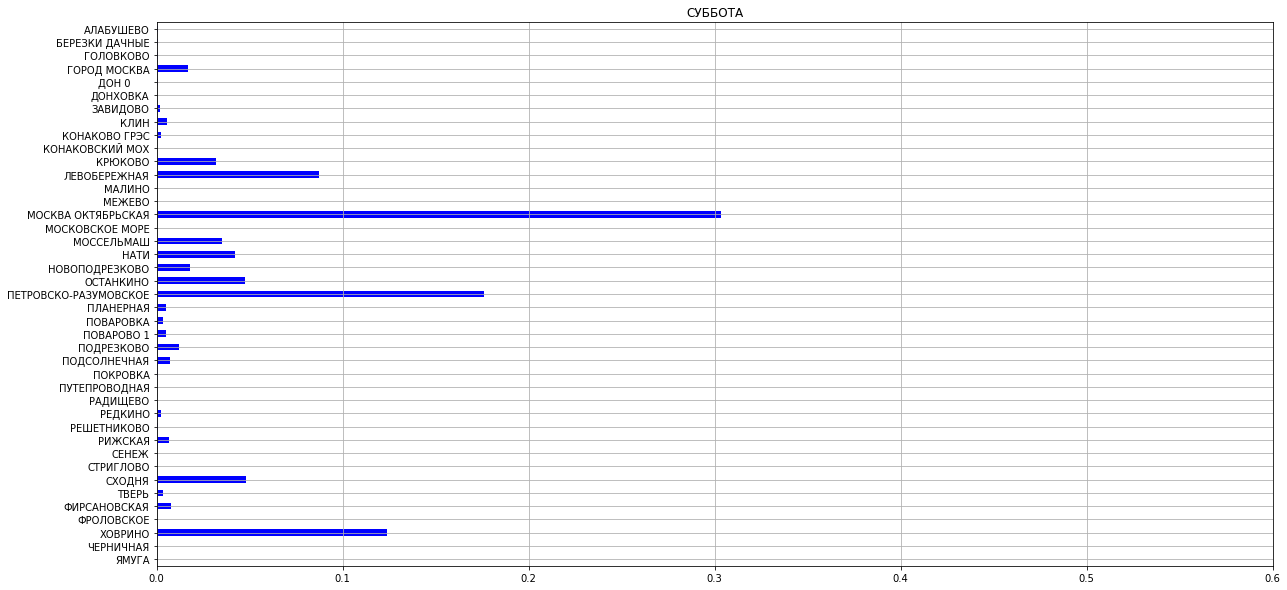

In [19]:
saturday = from_st_date[from_st_date['C_DATE_TR'].apply(lambda d: d.weekday() == 5)]
saturday = saturday['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
saturday.plot(kind='barh', title='СУББОТА', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

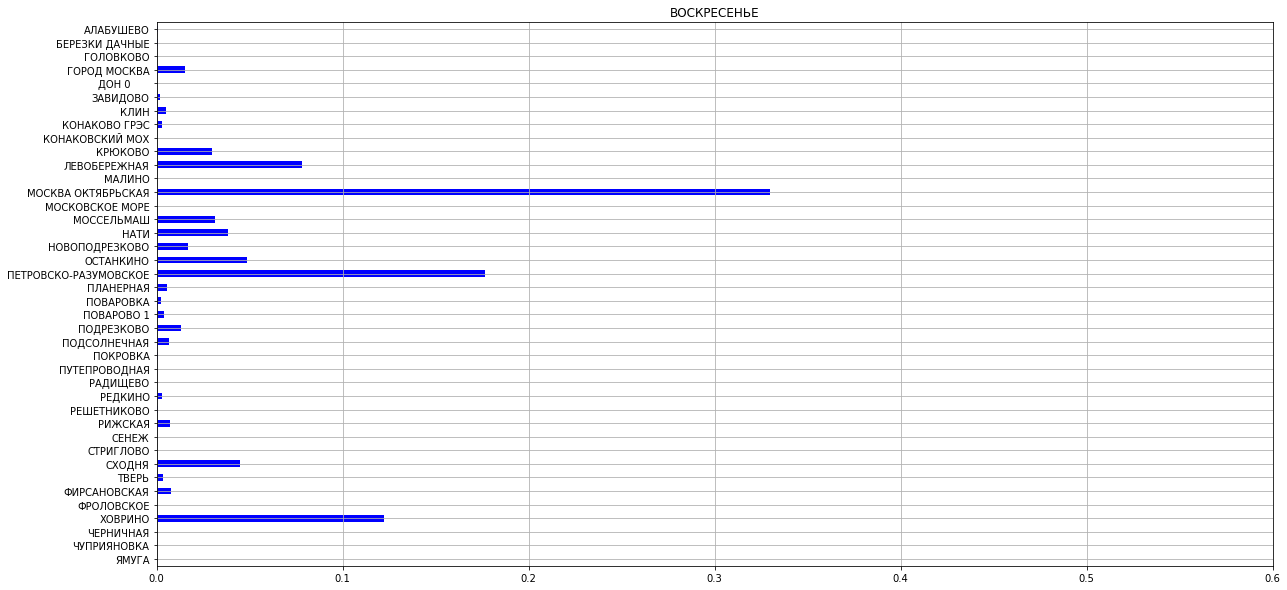

In [20]:
sunday = from_st_date[from_st_date['C_DATE_TR'].apply(lambda d: d.weekday() == 6)]
sunday = sunday['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
sunday.plot(kind='barh', title='ВОСКРЕСЕНЬЕ', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

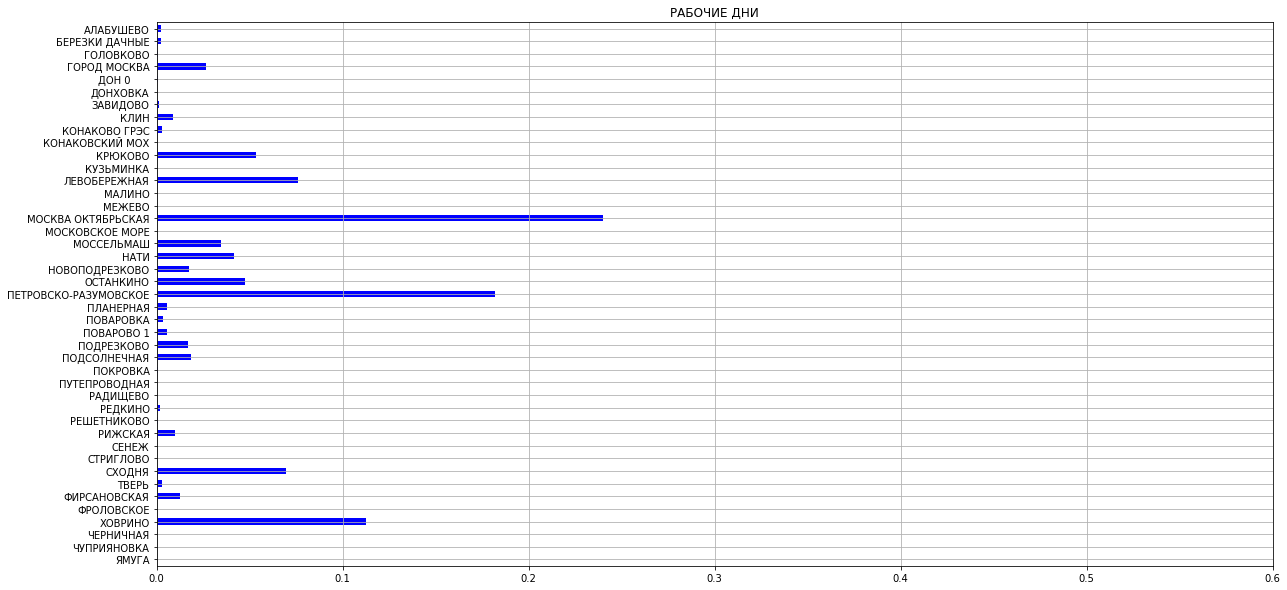

In [21]:
workdays = from_st_date[from_st_date['C_DATE_TR'].apply(lambda d: d.weekday() != 5 and d.weekday() != 6 and d != '23/02/2017' and d != '24/02/2017' and d != '08/03/2017')]
workdays = workdays['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
workdays.plot(kind='barh', title='РАБОЧИЕ ДНИ', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

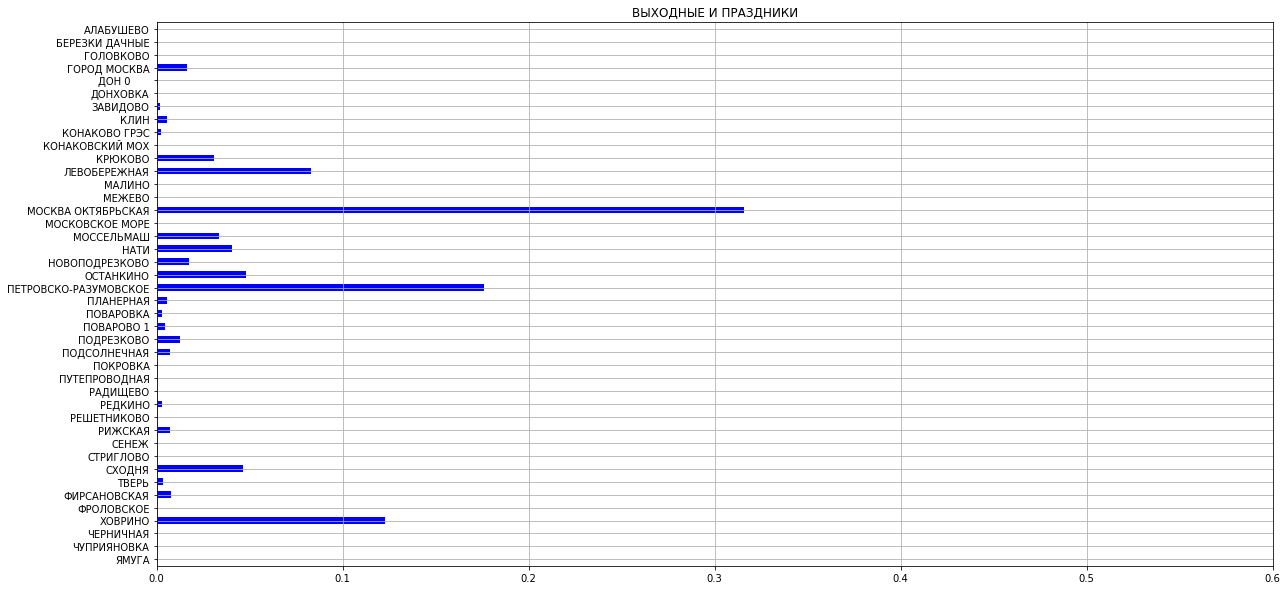

In [22]:
holidays = from_st_date[from_st_date['C_DATE_TR'].apply(lambda d: d.weekday() == 5 or d.weekday() == 6 or d == '23/02/2017' or d == '24/02/2017' or d == '08/03/2017')]
holidays = holidays['P_FROM_STR'].value_counts(normalize=True, sort=False).sort_index(ascending=False)
holidays.plot(kind='barh', title='ВЫХОДНЫЕ И ПРАЗДНИКИ', figsize=(20,10), grid=True, color='blue', xlim=(0,0.6))

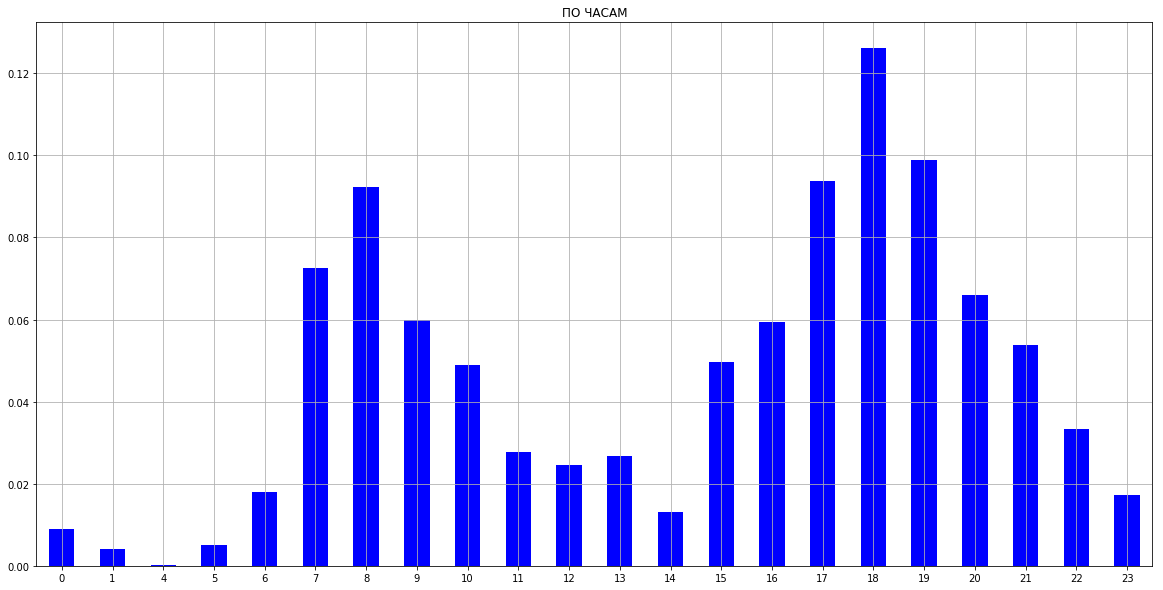

In [23]:
hours = df[df['P_FROM_STR'].apply(lambda P_FROM_STR: P_FROM_STR != 'ХИМКИ' and P_FROM_STR[0:8] != 'Экспресс')][['G_HOUR_TR']]
hours_s = hours['G_HOUR_TR'].value_counts(normalize=True, sort=False)
hours_s.plot(kind='bar', title='ПО ЧАСАМ', figsize=(20,10), grid=True, color='blue', rot=False)

In [24]:
peak = df[df['P_FROM_STR'].apply(lambda P_FROM_STR: P_FROM_STR != 'ХИМКИ' and P_FROM_STR[0:8] != 'Экспресс')][['G_HOUR_TR', 'P_FROM_STR']]
peak_8 = peak[peak['G_HOUR_TR'].apply(lambda p: p == 8)][['P_FROM_STR']]
print(peak_8['P_FROM_STR'].value_counts(normalize=True))

ХОВРИНО                  0.232042
ПЕТРОВСКО-РАЗУМОВСКОЕ    0.217293
МОСКВА ОКТЯБРЬСКАЯ       0.153733
ЛЕВОБЕРЕЖНАЯ             0.147229
МОССЕЛЬМАШ               0.055815
ОСТАНКИНО                0.047811
НАТИ                     0.046114
ГОРОД МОСКВА             0.043728
СХОДНЯ                   0.012909
КРЮКОВО                  0.010220
РИЖСКАЯ                  0.005860
КОНАКОВО ГРЭС            0.003957
ПОДСОЛНЕЧНАЯ             0.003493
КЛИН                     0.003466
ПОДРЕЗКОВО               0.003207
ФИРСАНОВСКАЯ             0.003118
ПЛАНЕРНАЯ                0.002394
ТВЕРЬ                    0.002314
НОВОПОДРЕЗКОВО           0.001671
ПОВАРОВО 1               0.001063
ПОВАРОВКА                0.000545
АЛАБУШЕВО                0.000491
ГОЛОВКОВО                0.000482
РЕДКИНО                  0.000259
ПОКРОВКА                 0.000143
ЗАВИДОВО                 0.000107
РЕШЕТНИКОВО              0.000107
БЕРЕЗКИ ДАЧНЫЕ           0.000107
КОНАКОВСКИЙ МОХ          0.000098
ДОН 0         

In [25]:
peak_18 = peak[peak['G_HOUR_TR'].apply(lambda p: p == 18)][['P_FROM_STR']]
print(peak_18['P_FROM_STR'].value_counts(normalize=True))

МОСКВА ОКТЯБРЬСКАЯ       0.208717
ПЕТРОВСКО-РАЗУМОВСКОЕ    0.152409
СХОДНЯ                   0.122153
КРЮКОВО                  0.105514
ХОВРИНО                  0.059572
ОСТАНКИНО                0.051863
НАТИ                     0.038964
ЛЕВОБЕРЕЖНАЯ             0.035543
ПОДСОЛНЕЧНАЯ             0.034042
МОССЕЛЬМАШ               0.029479
ПОДРЕЗКОВО               0.027984
НОВОПОДРЕЗКОВО           0.025132
ГОРОД МОСКВА             0.019949
ФИРСАНОВСКАЯ             0.015595
КЛИН                     0.015340
РИЖСКАЯ                  0.010712
КОНАКОВО ГРЭС            0.009302
ПЛАНЕРНАЯ                0.008395
ПОВАРОВО 1               0.007696
ПОВАРОВКА                0.006032
БЕРЕЗКИ ДАЧНЫЕ           0.004720
АЛАБУШЕВО                0.004112
ТВЕРЬ                    0.001860
РЕДКИНО                  0.000927
ГОЛОВКОВО                0.000751
ДОН 0                    0.000731
ЗАВИДОВО                 0.000718
РЕШЕТНИКОВО              0.000463
ФРОЛОВСКОЕ               0.000405
ПОКРОВКА      

In [26]:
df.head()

,A_ID_ZFILE,B_ZNAME,C_DATE_TR,D_KONC_NUM,E_TURNIK_ID,F_TURNIKET_TYPE,G_HOUR_TR,H_MINUTE_TR,I_CLASS_P,J_NAME_P,...,N_NAME_KT,O_TIC_STR,P_FROM_STR,Q_TO_STR,R_NOSITEL,S_NUM_BPMF,T_TYPE_NULL,U_NUM_TK,V_NUM_CRY,W_STATION
0,130,Z_05000_170101.01,01.01.2017,1,11,Вход,0,7,0,ПАССАЖИРСКИЙ,...,"Разовый ""туда""",Станции,ХИМКИ,ПОВАРОВО 1,Билет,52785,3.0,NaN,NaN,ХИМКИ
1,130,Z_05000_170101.01,01.01.2017,1,10,Вход,0,7,0,ПАССАЖИРСКИЙ,...,"Разовый ""туда""",Станции,ХИМКИ,ПОВАРОВО 1,Билет,52785,2.0,NaN,NaN,ХИМКИ
2,130,Z_05000_170101.01,01.01.2017,1,11,Вход,0,21,0,ПАССАЖИРСКИЙ,...,"Разовый ""туда""",Станции,ХИМКИ,СХОДНЯ,Билет,52785,4.0,NaN,NaN,ХИМКИ
3,130,Z_05000_170101.01,01.01.2017,1,11,Вход,0,23,0,ПАССАЖИРСКИЙ,...,"Разовый ""туда""",Станции,ХИМКИ,СХОДНЯ,Билет,52785,5.0,NaN,NaN,ХИМКИ
4,130,Z_05000_170101.01,01.01.2017,1,9,Вход,0,23,0,ПАССАЖИРСКИЙ,...,"Разовый ""туда""",Станции,ХИМКИ,СХОДНЯ,Билет,52785,6.0,NaN,NaN,ХИМКИ


In [27]:
from_st_date.head()

,P_FROM_STR,C_DATE_TR
5,ЛЕВОБЕРЕЖНАЯ,2017-01-01
13,СХОДНЯ,2017-01-01
14,СХОДНЯ,2017-01-01
21,ПЕТРОВСКО-РАЗУМОВСКОЕ,2017-01-01
24,СХОДНЯ,2017-01-01


In [28]:
hours_series = df[df['P_FROM_STR'].apply(lambda P_FROM_STR: P_FROM_STR != 'ХИМКИ' and P_FROM_STR[0:8] != 'Экспресс')][['C_DATE_TR', 'G_HOUR_TR']]
#hours_s = hours['G_HOUR_TR'].value_counts(normalize=True, sort=False)
#hours_s.plot(kind='bar', title='ПО ЧАСАМ', figsize=(20,10), grid=True, color='blue', rot=False)
grouped = hours_series.groupby(['C_DATE_TR', 'G_HOUR_TR']).size().reset_index(name='count')
#grouped.aggregate('count')
#print df1.groupby(["Name", "City"]).size().reset_index(name='count')
#grouped = hours_series.groupby(['C_DATE_TR', 'G_HOUR_TR'], as_index=False)[['count']].count()
grouped.head()

,C_DATE_TR,G_HOUR_TR,count
0,01.01.2017,0,11
1,01.01.2017,1,70
2,01.01.2017,5,64
3,01.01.2017,6,32
4,01.01.2017,7,59


In [29]:
hours_series.tail()

,C_DATE_TR,G_HOUR_TR
2207390,30.06.2017,23
2207391,30.06.2017,23
2207393,30.06.2017,23
2207394,30.06.2017,23
2207397,30.06.2017,23


In [30]:
grouped[3000:3050]

,C_DATE_TR,G_HOUR_TR,count
3000,25.01.2017,1,28
3001,25.01.2017,5,33
3002,25.01.2017,6,136
3003,25.01.2017,7,685
3004,25.01.2017,8,823
3005,25.01.2017,9,529
3006,25.01.2017,10,382
3007,25.01.2017,11,217
3008,25.01.2017,12,186
3009,25.01.2017,13,78


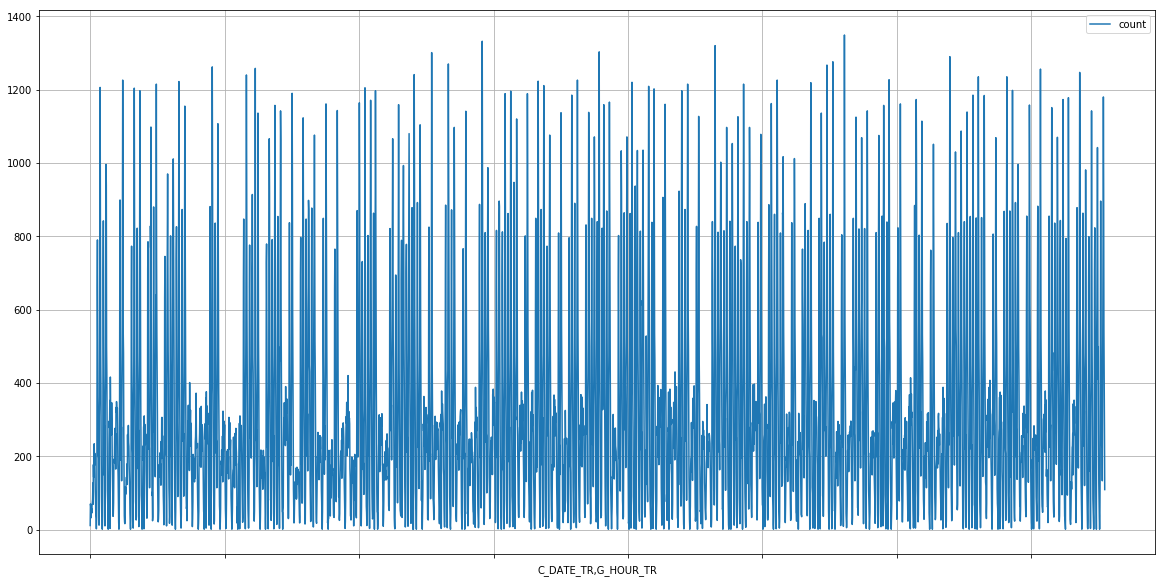

In [31]:
grouped.plot(x=['C_DATE_TR', 'G_HOUR_TR'], y='count', figsize=(20,10), grid=True)

In [32]:
grouped.head()

,C_DATE_TR,G_HOUR_TR,count
0,01.01.2017,0,11
1,01.01.2017,1,70
2,01.01.2017,5,64
3,01.01.2017,6,32
4,01.01.2017,7,59


In [33]:
grouped.tail()

,C_DATE_TR,G_HOUR_TR,count
3769,31.05.2017,19,921
3770,31.05.2017,20,544
3771,31.05.2017,21,427
3772,31.05.2017,22,278
3773,31.05.2017,23,109


In [34]:
hours_cc = grouped
hours_cc['day_hour'] = hours_cc['C_DATE_TR'].astype(str) + ' ' + hours_cc['G_HOUR_TR'].astype(str) + ':00' 
hours_cc.day_hour = hours_cc.day_hour.apply(lambda day_hour: day_hour.replace('.', '/'))
hours_cc.day_hour = hours_cc['day_hour'].apply(lambda d: datetime.strptime(d, '%d/%m/%Y %H:%M'))

In [35]:
hours_cc.head()

,C_DATE_TR,G_HOUR_TR,count,day_hour
0,01.01.2017,0,11,2017-01-01 00:00:00
1,01.01.2017,1,70,2017-01-01 01:00:00
2,01.01.2017,5,64,2017-01-01 05:00:00
3,01.01.2017,6,32,2017-01-01 06:00:00
4,01.01.2017,7,59,2017-01-01 07:00:00


In [36]:
hours_test = hours_cc.drop(['C_DATE_TR', 'G_HOUR_TR'], axis=1)
#hours_test.reset_index()
hours_test.set_index('day_hour', inplace=True, drop=True)
#hours_test.isna().sum()
#df['ID'] = df['ID'].astype('int64')
#hours_test['count'] = hours_test['count'].astype('Int64')
hours_test.shape[0]

3774

In [37]:
hours_cnt = hours_cc.groupby(['G_HOUR_TR']).size().reset_index(name='count')
hours_cnt

,G_HOUR_TR,count
0,0,180
1,1,180
2,4,74
3,5,181
4,6,181
5,7,181
6,8,181
7,9,181
8,10,180
9,11,157


In [38]:
dataset = hours_test
dataset = dataset.rename(columns={'count': 'passengers'})

In [40]:
def show_distr(data, day, hour):
    data = pd.DataFrame(data.copy())
    data.index = data.index.to_datetime()
    data_need = data.loc[(data.index.hour == hour) & (data.index.weekday == day)]
    data_need.sort_index(inplace=True)
    data_need.plot(figsize=(16, 8), grid=True)
    #data_need.head()
    return data_need

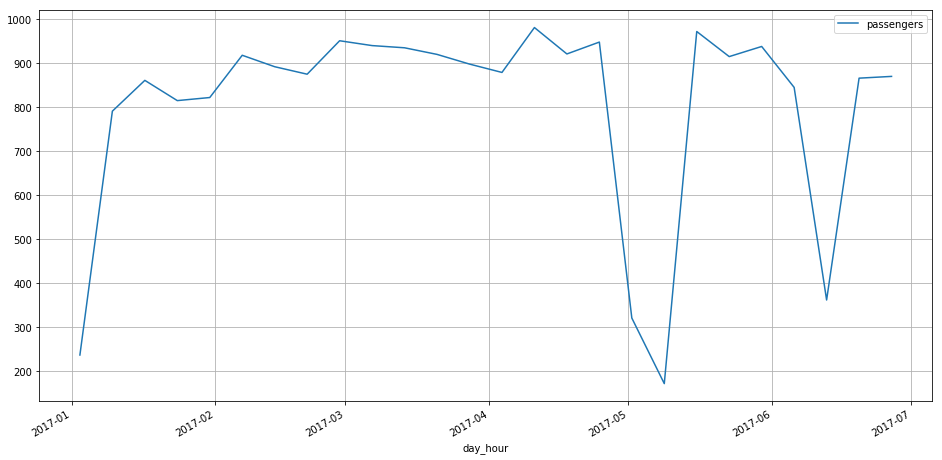

In [41]:
kk = show_distr(dataset, 0, 19)

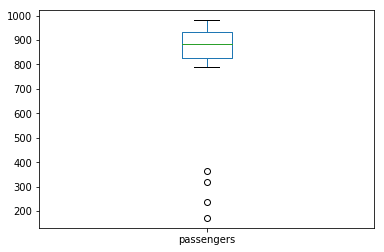

In [42]:
kk.plot(kind='box')

In [43]:
kk.head()

,passengers
day_hour,
2017-01-02 19:00:00,237
2017-01-09 19:00:00,791
2017-01-16 19:00:00,861
2017-01-23 19:00:00,815
2017-01-30 19:00:00,822


In [44]:
low = kk.quantile(0.25)
high = kk.quantile(0.75)

In [45]:
kk.loc[(kk.passengers < low[0]-1.5*(high[0]-low[0])) | (kk.passengers > high[0]+1.5*(high[0]-low[0]))]

,passengers
day_hour,
2017-01-02 19:00:00,237
2017-05-01 19:00:00,321
2017-05-08 19:00:00,172
2017-06-12 19:00:00,362


In [46]:
kk.shape

(26, 1)

In [47]:
kk.head(10)

,passengers
day_hour,
2017-01-02 19:00:00,237
2017-01-09 19:00:00,791
2017-01-16 19:00:00,861
2017-01-23 19:00:00,815
2017-01-30 19:00:00,822
2017-02-06 19:00:00,918
2017-02-13 19:00:00,892
2017-02-20 19:00:00,875
2017-02-27 19:00:00,951


In [48]:
kk.sort_index()

,passengers
day_hour,
2017-01-02 19:00:00,237
2017-01-09 19:00:00,791
2017-01-16 19:00:00,861
2017-01-23 19:00:00,815
2017-01-30 19:00:00,822
2017-02-06 19:00:00,918
2017-02-13 19:00:00,892
2017-02-20 19:00:00,875
2017-02-27 19:00:00,951


In [49]:
dataset.head()

,passengers
day_hour,
2017-01-01 00:00:00,11
2017-01-01 01:00:00,70
2017-01-01 05:00:00,64
2017-01-01 06:00:00,32
2017-01-01 07:00:00,59


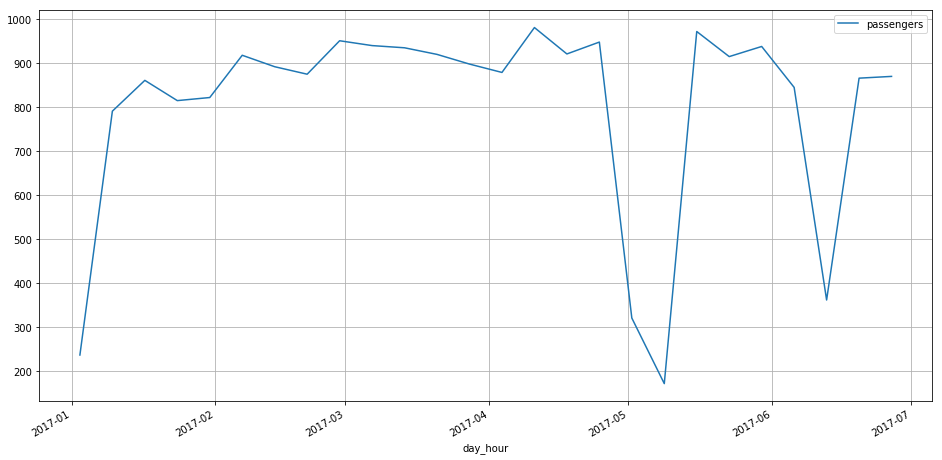

In [50]:
mon19 = show_distr(dataset, 0, 19)

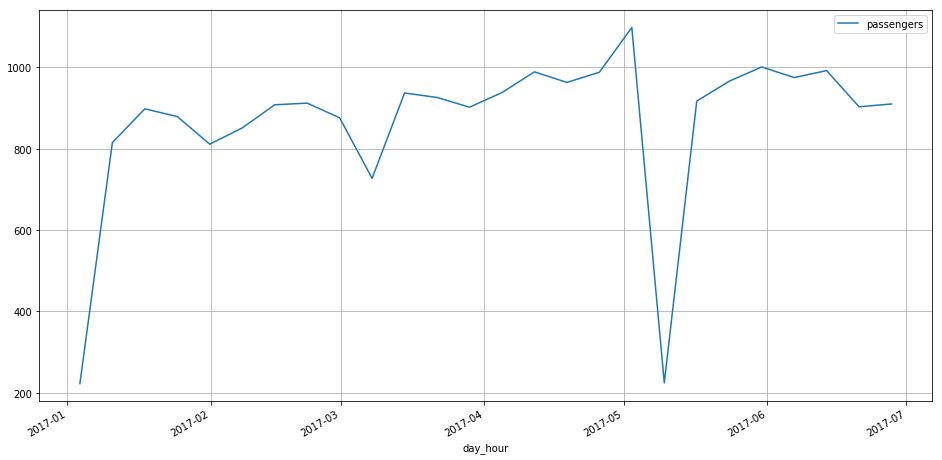

In [51]:
tue19 = show_distr(dataset, 1, 19)

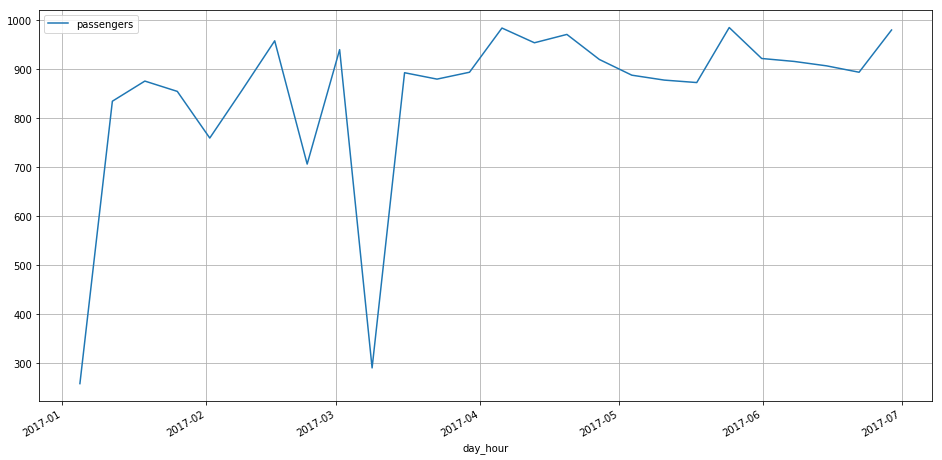

In [52]:
wed19 = show_distr(dataset, 2, 19)

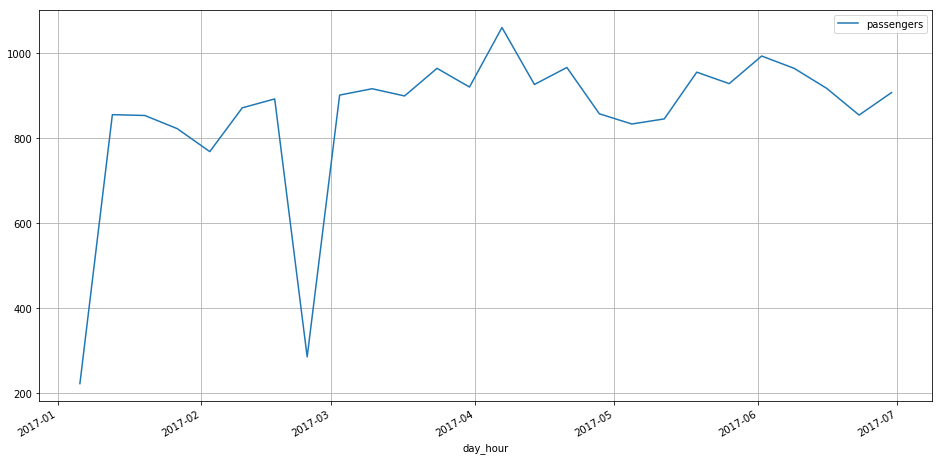

In [53]:
thu19 = show_distr(dataset, 3, 19)

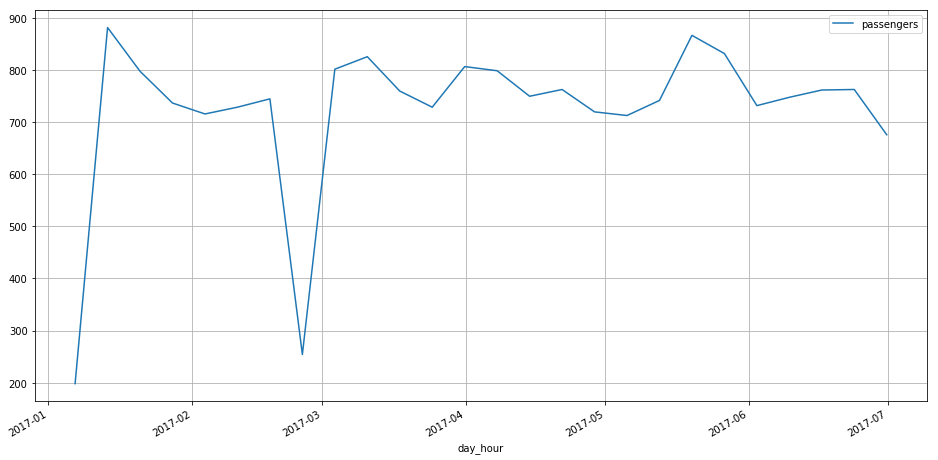

In [54]:
fri19 = show_distr(dataset, 4, 19)

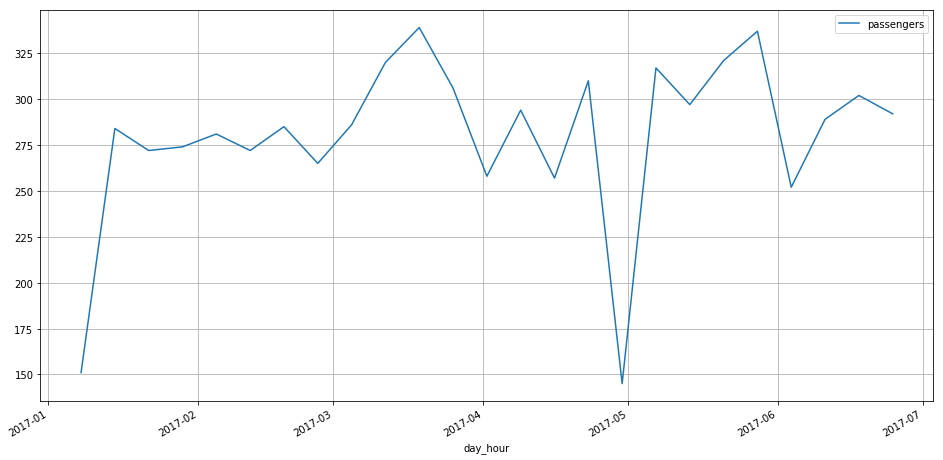

In [55]:
sat19 = show_distr(dataset, 5, 19)

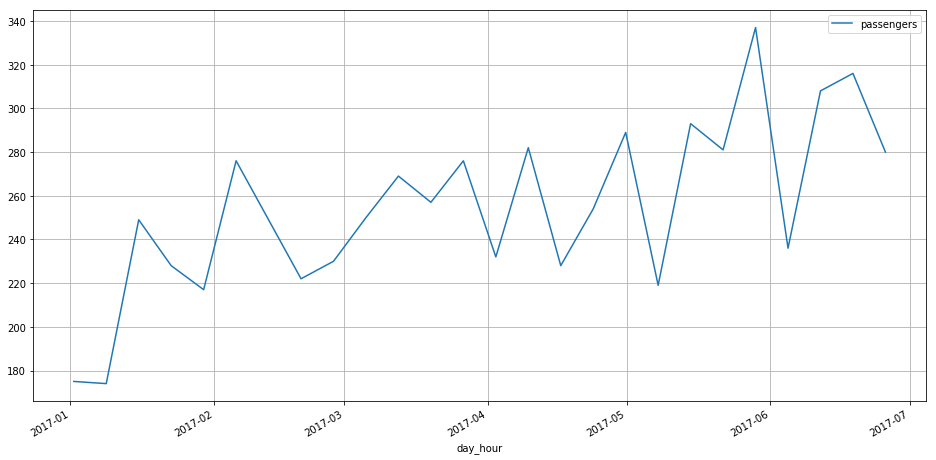

In [56]:
sun19 = show_distr(dataset, 6, 19)

In [57]:
sun19.size

26

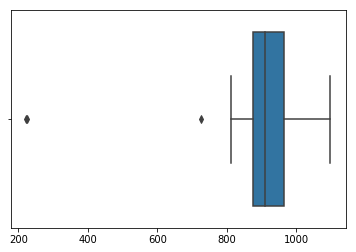

In [58]:
sns.boxplot(tue19)

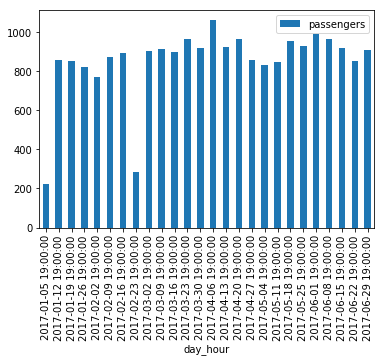

In [95]:
thu19.plot(kind='bar')

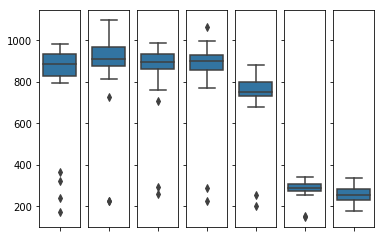

In [59]:
f, ax = plt.subplots(1, 7, sharey=True)
sns.boxplot(mon19, orient='v', ax=ax[0])
sns.boxplot(tue19, orient='v', ax=ax[1])
sns.boxplot(wed19, orient='v', ax=ax[2])
sns.boxplot(thu19, orient='v', ax=ax[3])
sns.boxplot(fri19, orient='v', ax=ax[4])
sns.boxplot(sat19, orient='v', ax=ax[5])
sns.boxplot(sun19, orient='v', ax=ax[6])

In [98]:
low_thu19 = thu19.quantile(0.25)[0]
high_thu19 = thu19.quantile(0.75)[0]
thu19.loc[(thu19.passengers < low_thu19-1.5*(high_thu19-low_thu19)) | (thu19.passengers > high_thu19+1.5*(high_thu19-low_thu19))]

,passengers
day_hour,
2017-01-05 19:00:00,223
2017-02-23 19:00:00,286
2017-04-06 19:00:00,1061


In [61]:
low_fri19 = fri19.quantile(0.25)[0]
high_fri19 = fri19.quantile(0.75)[0]
fri19.loc[(fri19.passengers < low_fri19-1.5*(high_fri19-low_fri19)) | (fri19.passengers > high_fri19+1.5*(high_fri19-low_fri19))]

,passengers
day_hour,
2017-01-06 19:00:00,198
2017-02-24 19:00:00,254


In [62]:
def prepareData(data):
    
    data = pd.DataFrame(data.copy())
    #data.index = data.index.to_datetime()
    data['is_weekend'] = data.index.weekday.isin([5,6])*1
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data.loc[(data.index.day.isin([2,3,4,5,6])) & (data.index.month == 1), 'is_weekend'] = 1
    data.loc[(data.index.day == 23) & (data.index.month == 2), 'is_weekend'] = 1
    data.loc[(data.index.day == 24) & (data.index.month == 2), 'is_weekend'] = 1
    data.loc[(data.index.day == 8) & (data.index.month == 3), 'is_weekend'] = 1
    data.loc[(data.index.day.isin([1,8,9])) & (data.index.month == 5), 'is_weekend'] = 1
    data.loc[(data.index.day == 12) & (data.index.month == 6), 'is_weekend'] = 1
    data.sort_index(inplace=True)
    return data

In [63]:
data_1 = prepareData(dataset)

In [64]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3774 entries, 2017-01-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 4 columns):
passengers    3774 non-null int64
is_weekend    3774 non-null int32
hour          3774 non-null int64
weekday       3774 non-null int64
dtypes: int32(1), int64(3)
memory usage: 132.7 KB


In [65]:
data_1.tail(10)

,passengers,is_weekend,hour,weekday
day_hour,,,,
2017-06-30 14:00:00,120,0,14,4
2017-06-30 15:00:00,378,0,15,4
2017-06-30 16:00:00,485,0,16,4
2017-06-30 17:00:00,600,0,17,4
2017-06-30 18:00:00,981,0,18,4
2017-06-30 19:00:00,676,0,19,4
2017-06-30 20:00:00,468,0,20,4
2017-06-30 21:00:00,330,0,21,4
2017-06-30 22:00:00,227,0,22,4


In [66]:
def get_slice(data, day, hour):
    data = pd.DataFrame(data.copy())
    data_need = data.loc[(data.index.hour == hour) & (data.index.weekday == day)]
    data_need.sort_index(inplace=True)
    return data_need

In [67]:
thu191 = get_slice(data_1, 3, 19)

In [68]:
thu191.head(30)

,passengers,is_weekend,hour,weekday
day_hour,,,,
2017-01-05 19:00:00,223,1,19,3
2017-01-12 19:00:00,856,0,19,3
2017-01-19 19:00:00,854,0,19,3
2017-01-26 19:00:00,823,0,19,3
2017-02-02 19:00:00,769,0,19,3
2017-02-09 19:00:00,872,0,19,3
2017-02-16 19:00:00,893,0,19,3
2017-02-23 19:00:00,286,1,19,3
2017-03-02 19:00:00,902,0,19,3


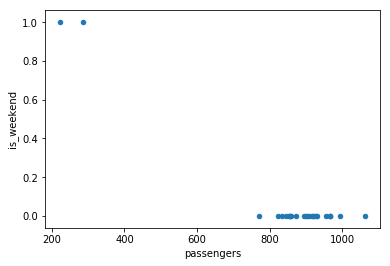

In [69]:
thu191.plot.scatter('passengers', 'is_weekend')

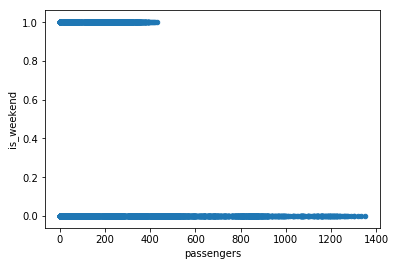

In [70]:
data_1.plot.scatter('passengers', 'is_weekend')

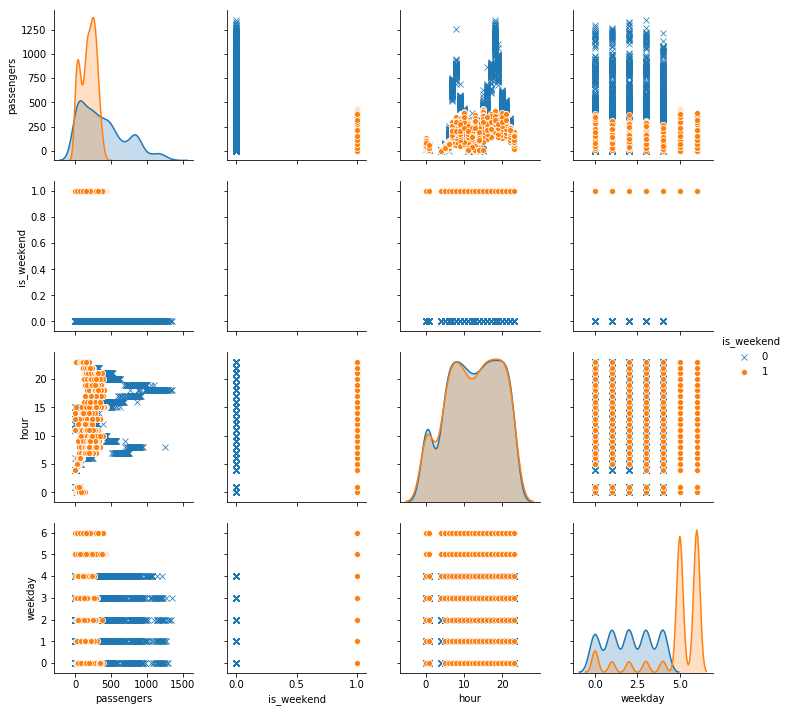

In [71]:
sns.pairplot(data_1, hue='is_weekend', markers=['x', 'o'])

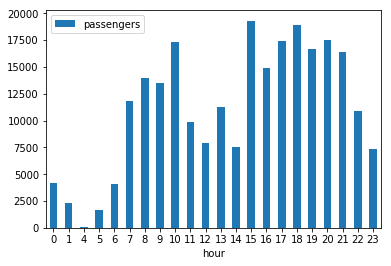

In [87]:
data_w = pd.DataFrame(data_1.copy())
data_w = data_w.loc[data_w.is_weekend == 1]
data_w[['passengers', 'hour']].groupby(['hour']).sum().plot.bar(rot=False)

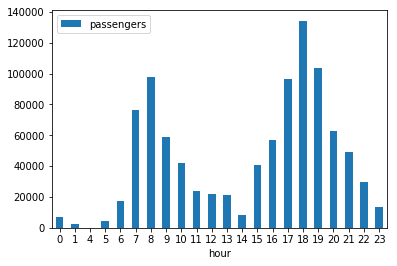

In [90]:
data_d = pd.DataFrame(data_1.copy())
data_d = data_d.loc[data_d.is_weekend == 0]
data_d[['passengers', 'hour']].groupby(['hour']).sum().plot.bar(rot=False)